# Assignment4

## Part1

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms, utils
import torch.optim as optim
import datetime
import random
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
# where to put the data
data_path = './'

# this constructs a CIFAR10 dataset, selects the training part of it, 
# downloads it if necessary, and adds additional transforms that we 
# will need to convert each image to a pytorch tensor AND to provide
# a nice conversion of the RGB images into greyscale
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

Files already downloaded and verified
Files already downloaded and verified


In [3]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [4]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label])
          for img, label in cifar10
          if label in [0, 2]]
cifar2_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in [0, 2]]

In [15]:
label_map = {1: 0, 3: 1, 4: 2, 5: 3, 6: 4, 7: 5, 8: 6, 9: 7}
class_names = ['automobile','cat','deer',
               'dog','frog','horse','ship','truck']

cifar2_test = [(img, label_map[label])
              for img, label in cifar10_val
              if label  not in [0, 2]]

In [5]:
device = (torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))
print(f"Training on device {device}.")

Training on device cuda.


In [6]:
def training_loop(n_epochs, optimizer, model, loss_fn, dataloader_dict):
    device = (torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))

    model.to(device)

    train_acc_list = []
    val_acc_list = []
    
    for epoch in range(1, n_epochs + 1):
        # print('Epoch {}/{}'.format(epoch, n_epochs))
        # print('-'*20)
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            loss_train = 0.0
            epoch_correct = 0
            for imgs, labels in dataloader_dict[phase]:
                imgs, labels = imgs.to(device), labels.to(device)
                # zero the gradients and determine backpropagation
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(imgs)
                    loss = loss_fn(outputs, labels)
                    _, preds = torch.max(outputs, 1)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    loss_train += loss.item() * imgs.size(0)
                    epoch_correct += torch.sum(preds == labels.data)
            epoch_loss = loss_train / len(dataloader_dict[phase].dataset)
            epoch_acc = epoch_correct.double() / len(dataloader_dict[phase].dataset)
            if phase == 'train':
                train_acc_list.append(epoch_acc.cpu())
            else:
                val_acc_list.append(epoch_acc.cpu())
            # print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
    
    return train_acc_list, val_acc_list

In [7]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,shuffle=False)
dataloaders_dict = {"train": train_loader, "val": val_loader}

In [ ]:
test_loader = torch.utils.data.DataLoader(cifar2_test, batch_size=100, shuffle=True)

In [8]:
def get_random_seeds(seeds):
    assert len(seeds) > 20, "Need at least 20 seeds"
    random_seed = random.sample(seeds, 20)

    return random_seed

In [9]:
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    os.environ["PYTHONHASHSEED"] = str(seed)

In [10]:
def experiment(random_seeds, model, n_epochs, learning_rate, dataloaders_dict):
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    for seed in random_seeds:
        set_seed(seed)
        for layer in model.children():
            if hasattr(layer, 'reset_parameters'):
                layer.reset_parameters()
        loss_fn = nn.CrossEntropyLoss()

        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        train, val = training_loop(n_epochs, optimizer, model, loss_fn, dataloaders_dict)
        errors = [t-v for t,v in zip(train,val)]
        plt.errorbar(range(1, n_epochs + 1), train, yerr=errors, label="train")
        plt.errorbar(range(1, n_epochs + 1), val, yerr=errors, label="val")
        plt.title("Training and Validation Accuracy for seed {}".format(seed))
        plt.legend(loc="upper left")
        plt.show()

In [11]:
random_seeds = get_random_seeds(range(1000))
model = Net()

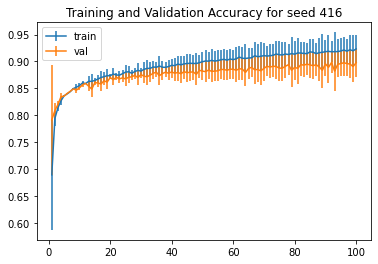

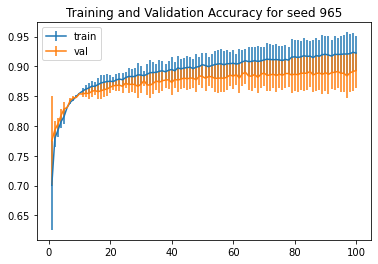

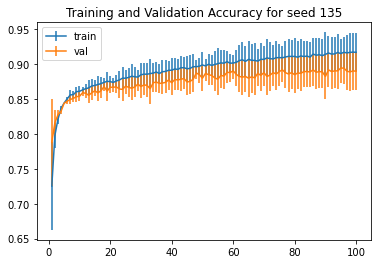

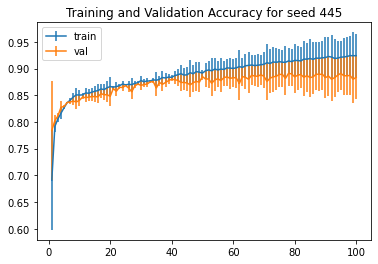

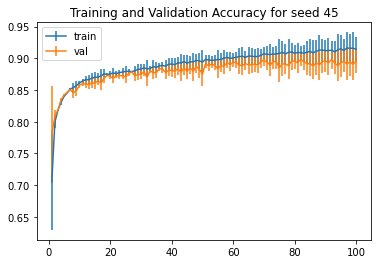

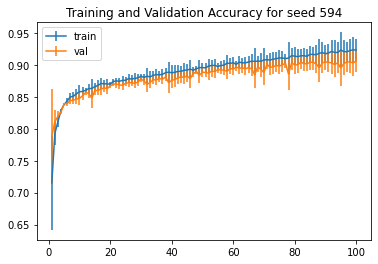

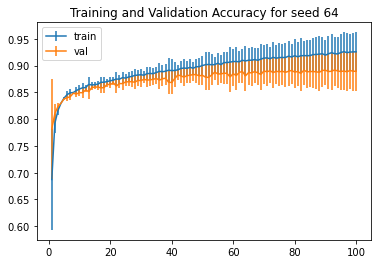

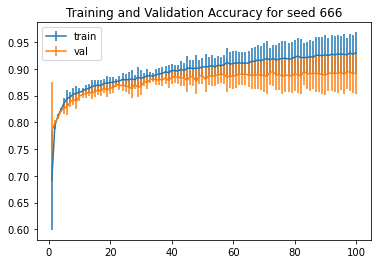

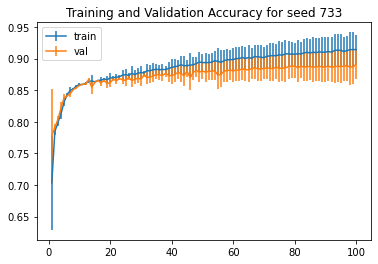

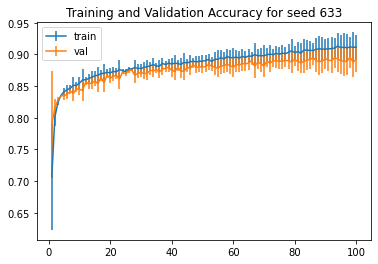

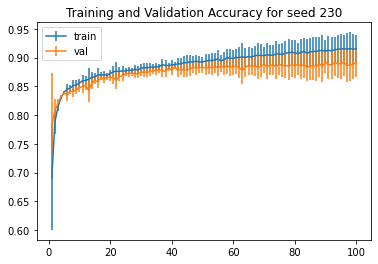

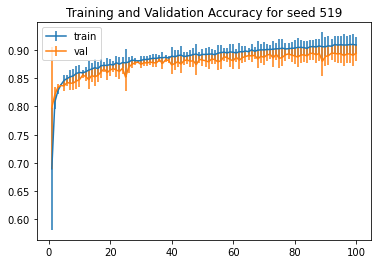

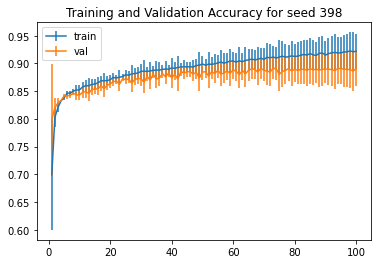

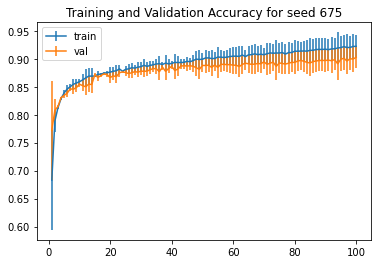

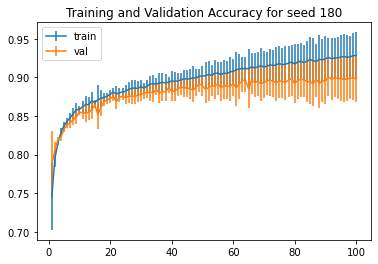

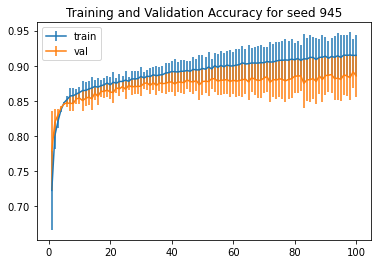

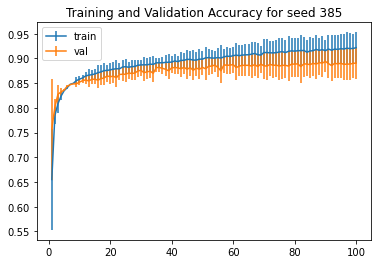

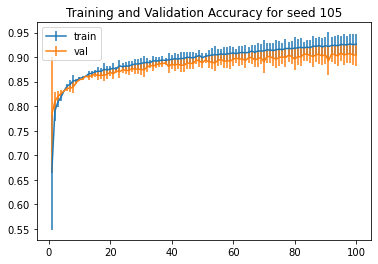

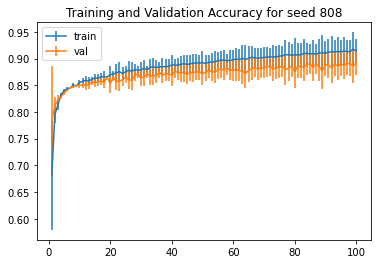

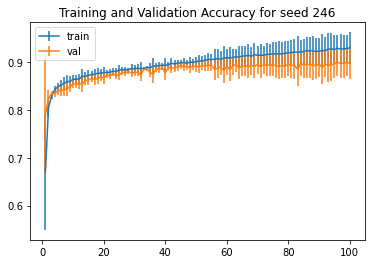

In [12]:
experiment(random_seeds, model, 100, 1e-4, dataloaders_dict)

### Q1
The network has been trained well, it can be seen in the accuracies increasing durning the iteration.

### Q2
I think it's not that large, because it has a little different on accuracies, but the diffences is about 1~2%.

### Q3
새로 학습하란거임? 모르겠음 

### Q4
No I wouldn't use it for real world, because the model was trained with too small resolution data and, for real world data, there could be occlusion and some other noises. So, I think the model couldn't classify well.

## Part2